# Compression d'images utilisant FFT

#### Définition de la fonction d'imagerie d'images multiples

In [1]:
from skimage import img_as_float

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap='gray',vmin=vmin, vmax=vmax)
        ax.set_title(label)

# Étapes de codification, de compression et de décodage d'image

Nous créerons des fonctions pour l'implémentation de a) codage, b) compression et c) décodage d'image (téléchargez l'image à partir de [εδώ](https://drive.google.com/file/d/1EzljukzZIIrRO4KeqVI-MFDrhQbjJvvN/view?usp=sharing).



In [2]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import scipy
from scipy.fftpack import fft2,fftshift,ifftshift,ifft2
from scipy.fftpack import dct, idct

from skimage import io,color,img_as_float,img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from numpy import r_
import cv2
#from skimage.draw import line, polygon, circle, ellipse
from PIL import Image 
import math

## Étape 1: codification de l'image




### a) lecture d'image et conversion en espace colorimétrique YCBCR

In [3]:
# Read flowers.tif
image=io.imread('./image/flowers.tif')
h=image.shape[0]
w=image.shape[1]
d=image.shape[2]

In [4]:
#RGBtoYCbCrChannel(image)
#input RGB image -> outup Y, Cb, Cr channel , 
#Y:Luminance  Cr = R – Y ( how far is the red component from Luminance)
#Cb = B – Y ( how far is the blue component from Luma ).

def RGBtoYCbCrChannel(image):
   RGB_image = img_as_float(image)
   YCbCr_image =color.rgb2ycbcr(RGB_image)
   YCbCr_image = YCbCr_image.astype(np.uint8)
   #print("type, min, max:", RGB_image.dtype, RGB_image.min(), RGB_image.max())
   print("type, min, max:", YCbCr_image.dtype, YCbCr_image.min(), YCbCr_image.max())
   #YCbCr_image.shape
   Y_channel=img_as_float(YCbCr_image[:,:,0])
   Cb_channel=img_as_float(YCbCr_image[:,:,1])
   Cr_channel=img_as_float(YCbCr_image[:,:,2])

   f, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(20, 15))
   ax0.imshow(RGB_image)
   ax0.set_title('RGB', fontsize=12)
   ax1.imshow(YCbCr_image)
   ax1.set_title('YCbCr', fontsize=12)
   ax2.imshow(Y_channel)
   ax2.set_title('Y channel', fontsize=12)
   ax3.imshow(Cb_channel)
   ax3.set_title('Cb channel', fontsize=12)
   ax4.imshow(Cr_channel)
   ax4.set_title('Cr channel', fontsize=12)
     
   return Y_channel,Cb_channel,Cr_channel

type, min, max: uint8 16 235


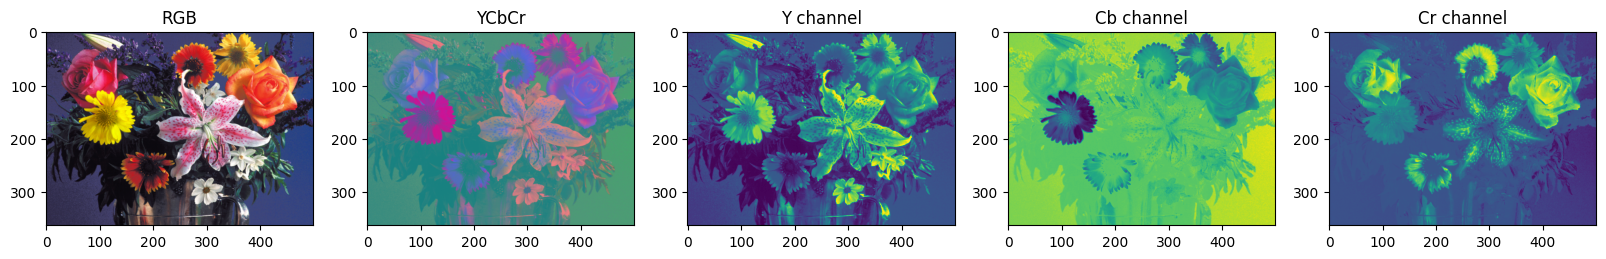

In [5]:
Y_channel,Cb_channel,Cr_channel=RGBtoYCbCrChannel(image)

### b) Utilisation de la transformation FFT dans toute l'image et dans des blocs 8x8 non-chevauchants (identiques que dans le laboratoire précédent)

In [6]:
def fft2block(a):
  imsize = a.shape
  im_fft = np.zeros(imsize)
  im_fft_shift = np.zeros(imsize)
  # Do 8x8 FFT on image (in-place)
  for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        im_fft[i:(i+8),j:(j+8)] = fft2( a[i:(i+8),j:(j+8)])
        im_fft_shift[i:(i+8),j:(j+8)] = fftshift( im_fft[i:(i+8),j:(j+8)])

  return im_fft_shift


def ifft2block(a):
   imsize = a.shape
   im_ifft = np.zeros(imsize)
   # Do 8x8 FFT on image (in-place)
   for i in r_[:imsize[0]:8]:
     for j in r_[:imsize[1]:8]:
       im_ifft[i:(i+8),j:(j+8)] = ifft2(ifftshift( a[i:(i+8),j:(j+8)]))
   return im_ifft




In [7]:
#FFT transform
Y_fft=fft2(Y_channel)
Cb_fft=fft2(Cb_channel)
Cr_fft=fft2(Cr_channel)
#Centrage spectre
Y_fftsh=fftshift(Y_fft)
Cb_fftsh=fftshift(Cb_fft)
Cr_fftsh=fftshift(Cr_fft)

#--------------------------------

#FFT 8x8 block
Y_fft_blk=fft2block(Y_channel)
Cb_fft_blk=fft2block(Cb_channel)
Cr_fft_blk=fft2block(Cr_channel)

/tmp/ipykernel_3327/3760939923.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  im_fft[i:(i+8),j:(j+8)] = fft2( a[i:(i+8),j:(j+8)])


## Étape 2: Compression d'image
### Utilisez un masque approprié pour couper des fréquences moins importantes

#### Mask pour couper moins d'éléments FFT importants (sur toute l'image ou le bloc)

In [8]:
# Création d'un masque elliptique pour FFT avec une taille personnalisée
# nx,ny: Hauteur et largeur du masque (Idem avec une image de masque à la taille de l'image sinon 8,8 pour les blocs)
# a,b : Pour la définition de petit et grand axe de valeurs manquantes: 1-5


def create_ellipse_mask(nx,ny,a,b): # a, b ellipse's lengths
   # set up a coordinate system    
  x = np.linspace(-5.0, 5.0, max(nx,ny))   #x=-5....elements oflinear space=max(nx,ny)..5
  y = np.linspace(-5.0, 5.0, max(nx,ny))
  # Setup arrays which just list the x and y coordinates
  xgrid, ygrid = np.meshgrid(x, y) 
  # Calculate the ellipse values all at once
  ellipse = xgrid**2 / a**2 + ygrid**2 / b**2
  # Create an array of int32 zeros
  grey = np.zeros((max(nx,ny),max(nx,ny)), dtype=np.int32)
  # Put 1's where ellipse is less than 1.0
  # Note ellipse <1.0 produces a boolean array that then indexes grey
  grey[ellipse < 1.0] = 1
  mask=np.zeros((nx,ny), dtype=np.int32)
  if (nx<ny):
    offset=math.trunc(np.round_((ny-nx)/2))
    mask = grey[offset:ny-offset, 0:ny]
  elif(nx>ny):
    offset=math.trunc(np.round_((nx-ny)/2))
    mask = grey[0:nx, offset:nx-offset]
  else:
    mask=grey
  return mask

### Application

#### a) Appliquer un masque pour couper moins d'importants articles FFT (tout au long de l'image)

In [9]:
maskY=create_ellipse_mask(Y_channel.shape[0],Y_channel.shape[1],3,2)
Y_fftsh_mask=Y_fftsh*maskY

maskCb=create_ellipse_mask(Cb_channel.shape[0],Cb_channel.shape[1],1,1)
Cb_fftsh_mask=Cb_fftsh*maskCb

maskCr=create_ellipse_mask(Cr_channel.shape[0],Cr_channel.shape[1],1,1)
Cr_fftsh_mask=Cr_fftsh*maskCr
 

Text(0.5, 1.0, 'Cb Channel after applying mask')

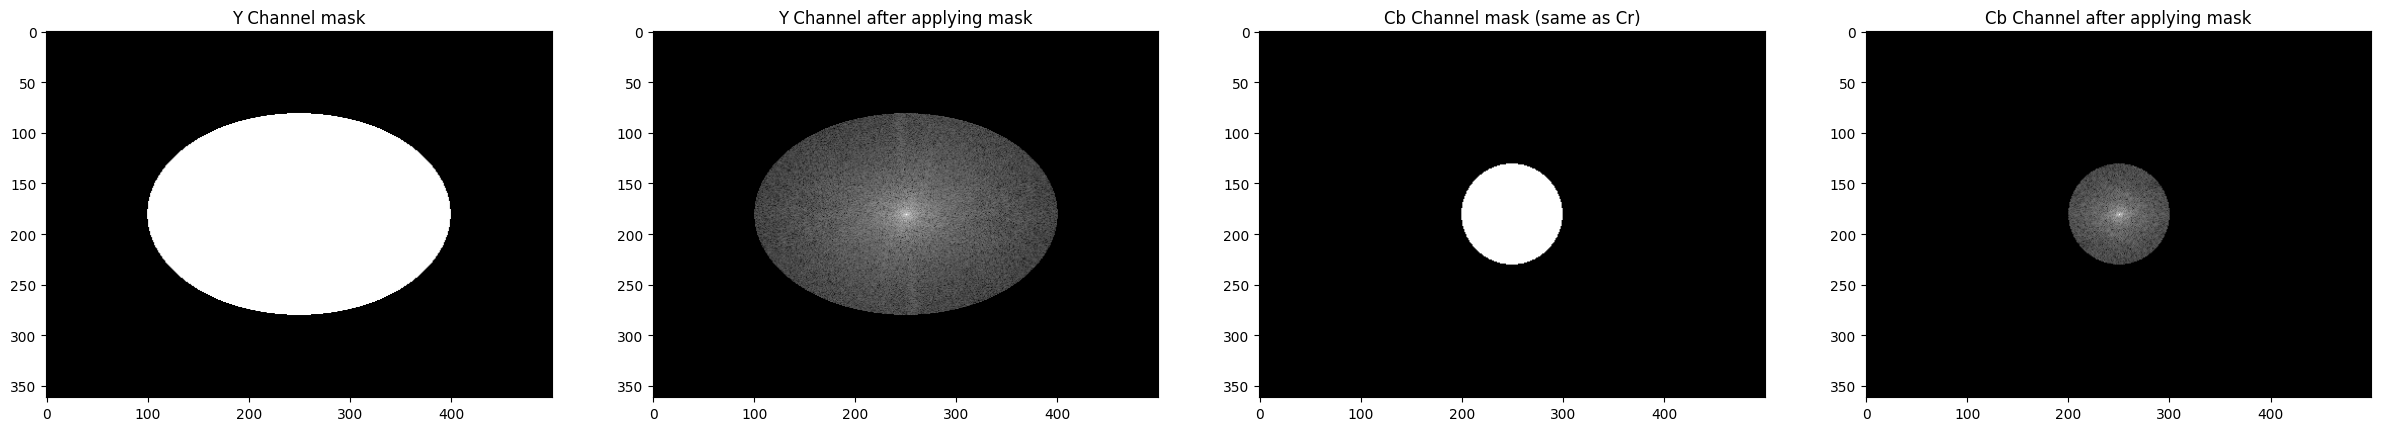

In [10]:
f, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(30, 20))

ax0.imshow(maskY,cmap='gray')
ax0.set_title('Y Channel mask', fontsize=12)

ax1.imshow(np.log10(1+abs(Y_fftsh_mask)), cmap='gray')
ax1.set_title('Y Channel after applying mask', fontsize=12)

ax2.imshow(maskCb,cmap='gray')
ax2.set_title('Cb Channel mask (same as Cr)', fontsize=12)

ax3.imshow(np.log10(1+abs(Cb_fftsh_mask)), cmap='gray')
ax3.set_title('Cb Channel after applying mask', fontsize=12)

#### b) Appliquer un masque pour couper moins d'éléments FFT importants (dans l'image du bloc 8x8)

In [11]:
maskblkfft=create_ellipse_mask(8,8,4,3)
maskblkfftY = cv2.filter2D(Y_fft_blk,-1,maskblkfft)
maskblkfft=create_ellipse_mask(8,8,1,1)
maskblkfftCb = cv2.filter2D(Cb_fft_blk,-1,maskblkfft)
maskblkfft=create_ellipse_mask(8,8,1,1)
maskblkfftCr = cv2.filter2D(Cr_fft_blk,-1,maskblkfft)

Text(0.5, 1.0, 'Cb Channel after applying mask')

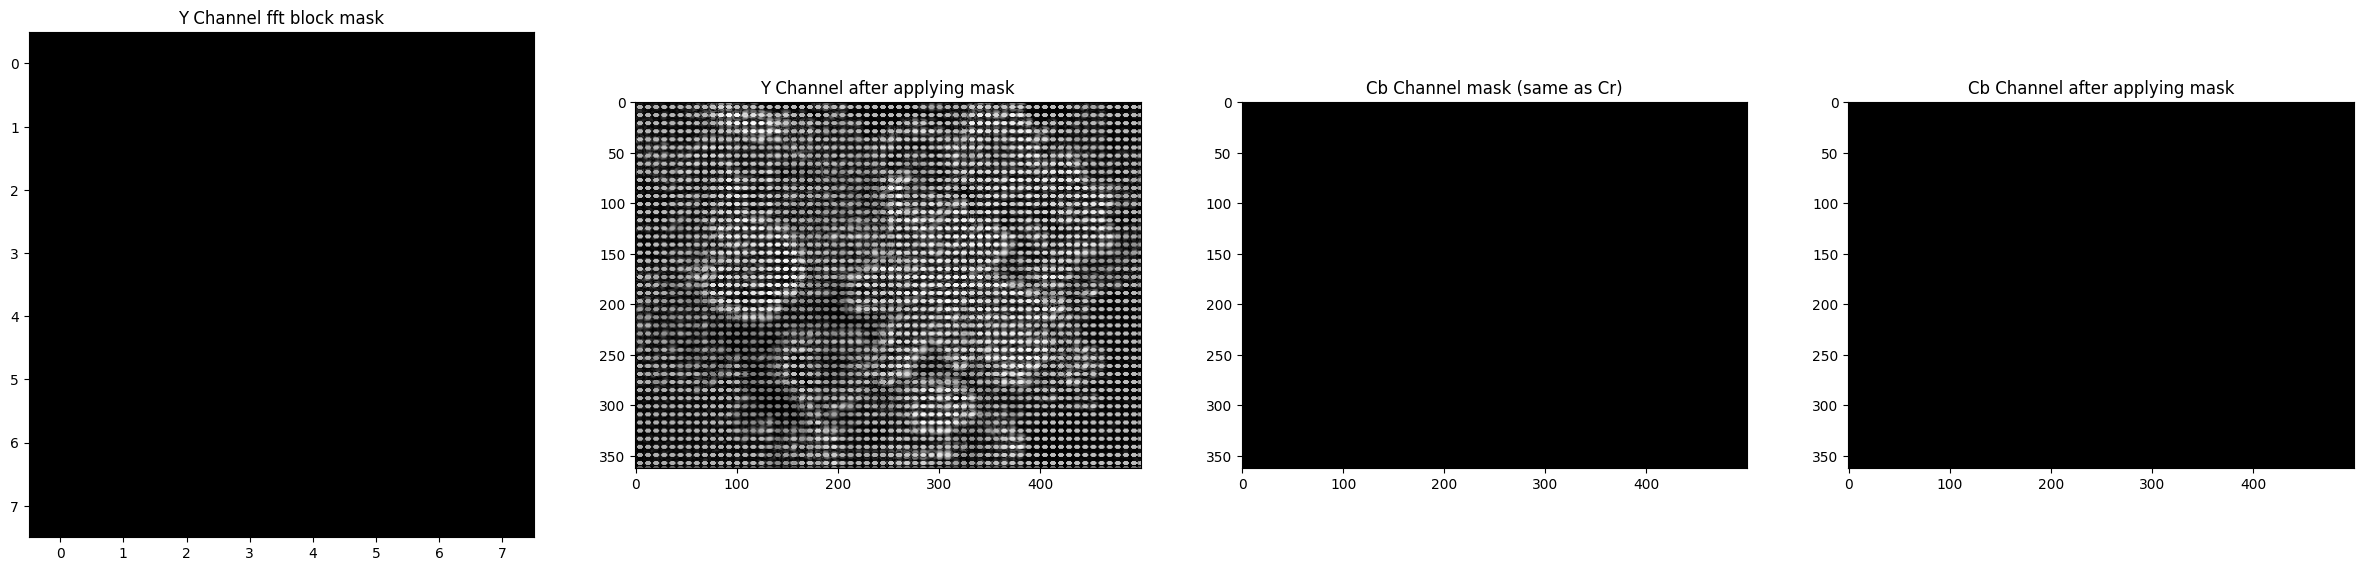

In [12]:
f, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(30, 20))

ax0.imshow(maskblkfft,cmap='gray')
ax0.set_title('Y Channel fft block mask', fontsize=12)

ax1.imshow(np.log10(1+abs(maskblkfftY)), cmap='gray')
ax1.set_title('Y Channel after applying mask', fontsize=12)

ax2.imshow(np.log10(1+abs(maskblkfftCr)),cmap='gray')
ax2.set_title('Cb Channel mask (same as Cr)', fontsize=12)

ax3.imshow(np.log10(1+abs(maskblkfftCb)), cmap='gray')
ax3.set_title('Cb Channel after applying mask', fontsize=12)

## Étape 3: Décodage d'image



#### Reverse Transformation FFT pour l'image Nous avons appliqué Compress avec un masque pour la même taille que l'image d'origine

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Lossy conversion from float32 to uint8. Range [-0.11321502178907394, 1.1611007452011108]. Convert image to uint8 prior to saving to suppress this warning.


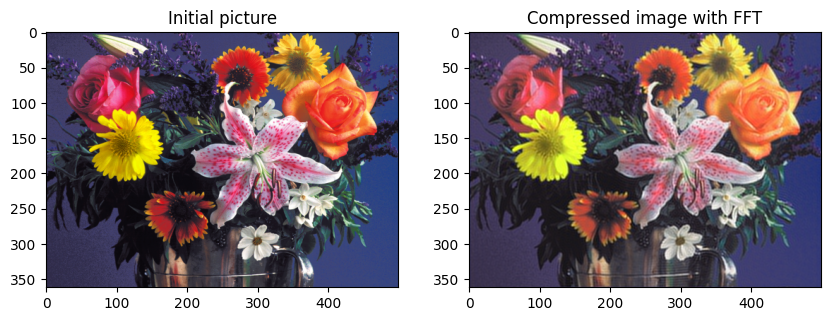

In [13]:
ifftYCbCr=np.zeros(image.shape) # initial image

ifftYCbCr[:,:,0]=abs(ifft2(ifftshift(Y_fftsh_mask)))
ifftYCbCr[:,:,1]=abs(ifft2(ifftshift(Cb_fftsh_mask)))
ifftYCbCr[:,:,2]=abs(ifft2(ifftshift(Cr_fftsh_mask)))

ifftYCbCr = ifftYCbCr.astype('float32')

ifftRGB = cv2.cvtColor(ifftYCbCr, cv2.COLOR_YCrCb2BGR)

#Imagerie et stockage de l'image comprimée
imshow_all(image,ifftRGB, titles= ['Initial picture','Compressed image with FFT'])
io.imsave('FFTcompressed.bmp', ifftRGB)

#### Reverse transformation fft pour l'image Nous avons appliqué la compression avec un masque 8x8 sur le bloc FFT

/tmp/ipykernel_3327/3760939923.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  im_ifft[i:(i+8),j:(j+8)] = ifft2(ifftshift( a[i:(i+8),j:(j+8)]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Lossy conversion from float32 to uint8. Range [0.08252153545618057, 1.1095490455627441]. Convert image to uint8 prior to saving to suppress this warning.


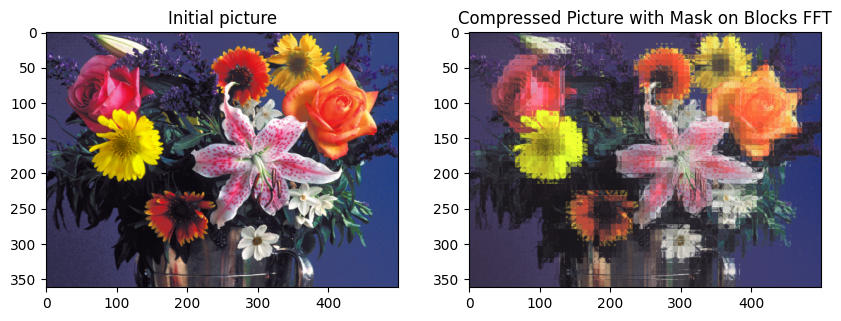

In [14]:
im_ifftblk = np.zeros(image.shape)

im_ifftblk[:,:,0]=ifft2block(Y_fft_blk)
im_ifftblk[:,:,1]=ifft2block(Cb_fft_blk)
im_ifftblk[:,:,2]=ifft2block(Cr_fft_blk)

im_ifftblk = im_ifftblk.astype('float32')
iblkfftRGB = cv2.cvtColor(im_ifftblk, cv2.COLOR_YCrCb2BGR)
iblkfftRGB =np.real(iblkfftRGB)

imshow_all(image,iblkfftRGB, titles= ['Initial picture','Compressed Picture with Mask on Blocks FFT'])
io.imsave('blkfft.bmp', iblkfftRGB)

#### PEAK TO Signal Noise Ratio-PSNR
Le PSNR exprime la différence de marque entre la valeur du signal maximale possible et la force de déformation du signal qui affecte sa qualité.Lorsque nous utilisons PSNR pour l'évaluation de la qualité d'image comme signal, nous définissons nos données d'origine (notre image d'origine) et la déformation est essentiellement le bruit introduit lors de la compression de notre image.

L'algorithme PSNR pour faire une estimation des utilisations de la qualité d'image
Le MSE (erreur carrée moyenne).MSE exprime la valeur carrée moyenne entre
de l'image originale (i) et déformé (i ').

$$ mse = \frac {1} {m, n} \sum _{i = 0} ^ {m-1} \sum _{j = 0} ^ {n-1} [I(i,j)-ι '(i, j)] ^ {2} $$

PSNR (en dB) est défini comme
$$ psnr = 10 \cdot log_{10} \frac {max_i ^ 2} {mse} = 20 \cdot log_{10} \frac {max_i} {\sqrt{mse}} = 20 \cdot log_{10} {{Max_i} -10 \cdot log_{10}} {mse} $$

La fourchette de prix varie de 0 à 100 dB et les prix entre 20 et 40 dB sont considérés comme acceptables tandis que les prix autour de 100 donnent des déformations maximales.

In [20]:
def psnr(compressed,original):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR




In [21]:
snrfft=psnr(ifftRGB,image)
snrfftblk=psnr(iblkfftRGB,image)
        
print('SNR FFT in the whole picture:',snrfft)
print('SNR FFT in Block 8x8 image:',snrfftblk)    

SNR FFT in the whole picture: 7.545552885138704
SNR FFT in Block 8x8 image: 7.544747916697505


### ratio de compression
$$ Ratio de compression = cr = \frac {size_{image non compressée}} {size_{image compressée}} $$

*Exemple*
> Laissez l'image d'origine est en taille (256x256) pixels x 8 bits par pixel, alors ils seront:
$ Size_{non compressé} $ = 65536 octets

> Laissez une compression de l'image d'origine a une taille $ size_{compressimage} $ = 6554 octets

alors $ cr $ = 9 999 = 10 ou $ cr 10: 1


## bits par pixels

Pour une image MXM, nous avons:
dollars

In [22]:
 
CRfft=sum(sum((Y_fftsh_mask != 0) + (Cb_fftsh_mask != 0) + (Cr_fftsh_mask != 0))) / (image.shape[0]*image.shape[1]*image.shape[2]);

print('Compression Ratio After FFT compression throughout the picture:',CRfft)


Compression Ratio After FFT compression throughout the picture: 0.08640147329650093
